In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

Files already downloaded and verified
Files already downloaded and verified


### Part 3.b.

### Learning Rate Finder

In [28]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    learning_rate_list = []
    correct = 0
    total = 0
    schedule_lr = 1e-5
    # print(schedule_lr)
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to configured device
        learning_rate_list.append(schedule_lr)
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Learning Rate: {:.5f}, Loss: {:.4f}'.format(1, 1, i+1, total_step,schedule_lr, loss.item()))

        # changing learning rate
        schedule_lr = schedule_lr * 1.1

        for op_params in optimizer.param_groups:
            op_params['lr'] = schedule_lr

        train_loss_values.append(loss.item())
        train_error.append(100-100*correct/total)

        if i == 100:
            break

        
    return train_error,train_loss_values, learning_rate_list

In [36]:
model = allcnn_t().to(device)
epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.001, nesterov=True)
train_error,train_loss_values, learning_rate_list= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/1], Step [1/391], Learning Rate: 0.00001, Loss: 2.3495
Epoch [1/1], Step [2/391], Learning Rate: 0.00001, Loss: 2.3148
Epoch [1/1], Step [3/391], Learning Rate: 0.00001, Loss: 2.3416
Epoch [1/1], Step [4/391], Learning Rate: 0.00001, Loss: 2.3064
Epoch [1/1], Step [5/391], Learning Rate: 0.00001, Loss: 2.2986
Epoch [1/1], Step [6/391], Learning Rate: 0.00002, Loss: 2.3140
Epoch [1/1], Step [7/391], Learning Rate: 0.00002, Loss: 2.3080
Epoch [1/1], Step [8/391], Learning Rate: 0.00002, Loss: 2.3033
Epoch [1/1], Step [9/391], Learning Rate: 0.00002, Loss: 2.3213
Epoch [1/1], Step [10/391], Learning Rate: 0.00002, Loss: 2.3042
Epoch [1/1], Step [11/391], Learning Rate: 0.00003, Loss: 2.2937
Epoch [1/1], Step [12/391], Learning Rate: 0.00003, Loss: 2.3268
Epoch [1/1], Step [13/391], Learning Rate: 0.00003, Loss: 2.2717
Epoch [1/1], Step [14/391], Learning Rate: 0.00003, Loss: 2.3026
Epoch [1/1], Step [15/391], Learning Rate: 0.00004, Loss: 2.2915
Epoch [1/

In [37]:
## saving these for plotting val_error,val_loss_values,train_error,train_loss_values
import numpy as np
np.save('train_error.npy', np.array(train_error))
np.save('train_loss_values.npy', np.array(train_loss_values))
np.save('learning_rate_list.npy', np.array(learning_rate_list))

In [10]:
torch.save(model, 'model1_100epoch_lr_hw4_part3b.pt')

In [8]:
model = torch.load('model1_100epoch_lr_hw4_part3b.pt')

In [1]:
import numpy as np
train_error = np.load('train_error.npy')
train_loss_values = np.load('train_loss_values.npy')
learning_rate_list = np.load('learning_rate_list.npy')
len(train_error), len(train_loss_values), len(learning_rate_list)

(101, 101, 101)

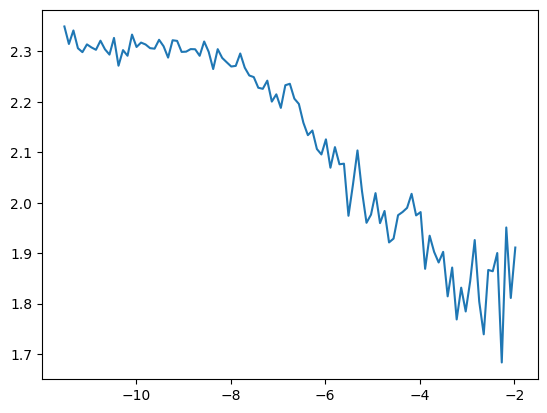

In [2]:
import matplotlib.pyplot as plt
plt.plot(np.log(learning_rate_list), train_loss_values)

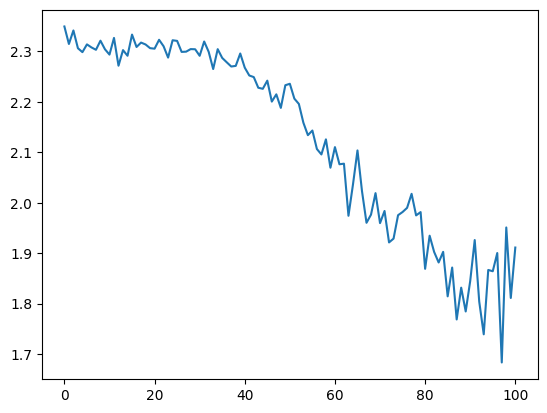

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_values)

In [38]:
## optimal learning rate
lr_opt = learning_rate_list[np.array([train_loss_values]).argmin()]
print('Optimal learning rate corresponding to least training loss {} is {} at index {}'.format(np.array([train_loss_values]).min(), lr_opt, np.array([train_loss_values]).argmin()))


Optimal learning rate corresponding to least training loss 1.683326005935669 is 0.10353578016395476 at index 97


### 3.c

##### Training the model based on learning rate scheduler after finding the optimal learning rate in 3.b

In [39]:
lr_max = lr_opt / 10
T = 100 * 391
T_0 = T / 5
def schedule_lr(epoch, itr):
    t = epoch*391 + itr
    if t <= T_0:
        return (1e-4 + (t/T_0)*lr_max)
    else:
        return (1e-6 + (lr_max * (np.cos(np.pi/2*((t - T_0)/(T - T_0))))))

In [40]:
# The training loop - changing the learning rate and weight decay as per suggestion given in the document

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    learning_rate_list = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        # print(schedule_lr)
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            lr = schedule_lr(epoch, i)
            learning_rate_list.append(lr)
            for op_params in optimizer.param_groups:
                op_params['lr'] = lr
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning Rate: {:.6f}'.format(epoch+1, epochs, i+1, total_step, running_loss/total, lr))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
            train_loss_values.append(loss.item())
            train_error.append(100-100*correct/total)

        running_loss = 0.0

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values, learning_rate_list

In [41]:
# model = allcnn_t().to(device)
epochs = 100
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values, learning_rate_list= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Epoch [1/100], Step [100/391], Loss: 0.0138, Learning Rate: 0.000231
Epoch [1/100], Step [200/391], Loss: 0.0137, Learning Rate: 0.000363
Epoch [1/100], Step [300/391], Loss: 0.0136, Learning Rate: 0.000496
Accuracy of the network on the test images: 35.57 %
Epoch [2/100], Step [100/391], Loss: 0.0125, Learning Rate: 0.000749
Epoch [2/100], Step [200/391], Loss: 0.0124, Learning Rate: 0.000881
Epoch [2/100], Step [300/391], Loss: 0.0123, Learning Rate: 0.001014
Accuracy of the network on the test images: 46.1 %
Epoch [3/100], Step [100/391], Loss: 0.0114, Learning Rate: 0.001266
Epoch [3/100], Step [200/391], Loss: 0.0113, Learning Rate: 0.001399
Epoch [3/100], Step [300/391], Loss: 0.0112, Learning Rate: 0.001531
Accuracy of the network on the test images: 51.44 %
Epoch [4/100], Step [100/391], Loss: 0.0103, Learning Rate: 0.001784
Epoch [4/100], Step [200/391], Loss: 0.0103, Learning Rate: 0.001917
Epoch [4/100], Step [300/391], Loss: 0.0102, Learning Rate: 0.002049
Accuracy of the n

In [46]:
#torch.save(model, './Intital_hw2_p3_model/model3_100epoch_40lr_1e4wt.pt')
torch.save(model, 'model1_100epoch_lr_hw4_p3.pt')

In [43]:
## saving these for plotting val_error,val_loss_values,train_error,train_loss_values  
import numpy as np
np.save('val_error_hw4_p3.npy', np.array(val_error))
np.save('val_loss_values_hw4_p3.npy', np.array(val_loss_values))
np.save('train_error_hw4_p3.npy', np.array(train_error))
np.save('train_loss_values_hw4_p3.npy', np.array(train_loss_values))
np.save('learning_rate_list_hw4_p3.npy', np.array(learning_rate_list))

In [4]:
val_error = np.load('val_error_hw4_p3.npy')

In [44]:
np.array(train_error).min(), np.array(train_error).max()

(0.0, 67.44791666666666)

In [45]:
np.array(val_error).min(), np.array(val_error).max()

(15.719999999999999, 64.43)

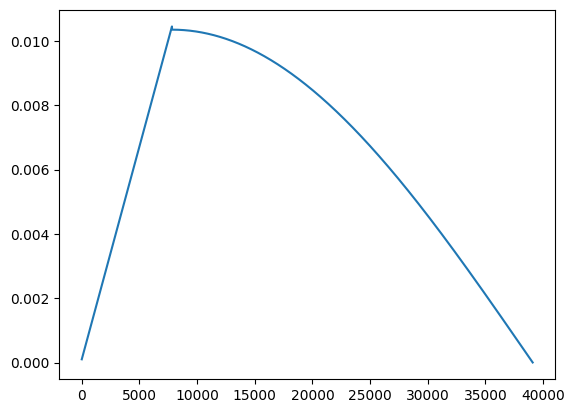

In [ ]:
plt.plot(learning_rate_list)

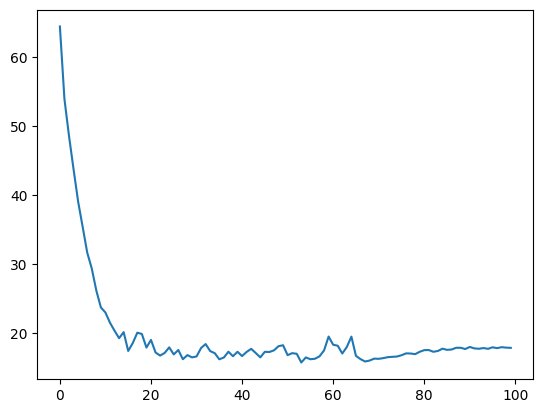

In [ ]:
plt.plot(val_error)

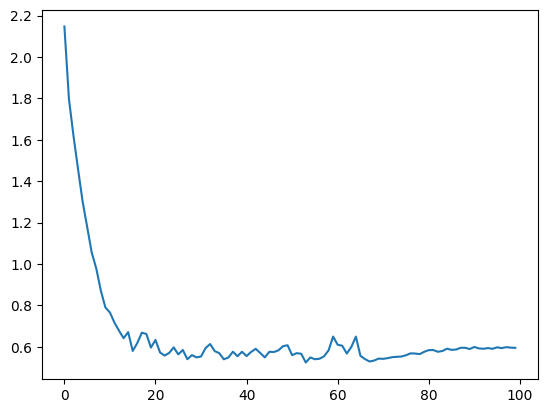

In [5]:
plt.plot(val_error/30)

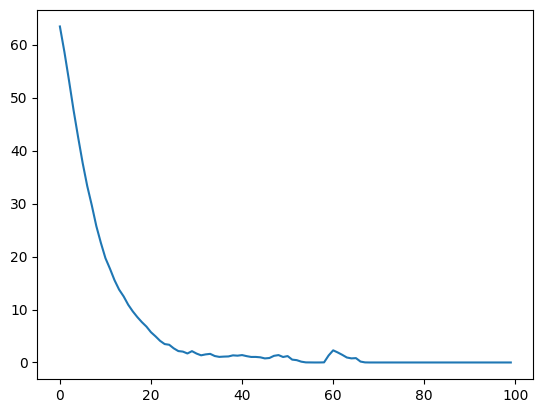

In [ ]:
mean_train_error = []
for i in range(0,len(train_error), 391):
    mean_train_error.append(np.mean(np.array(train_error[i:i+391])))
plt.plot(mean_train_error)

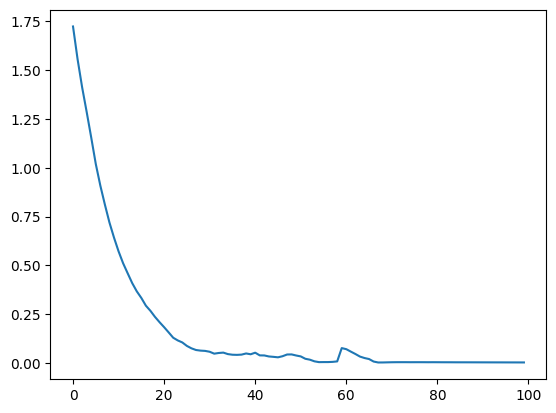

In [ ]:
mean_train_loss_values = []
for i in range(0,len(train_loss_values), 391):
    mean_train_loss_values.append(np.mean(np.array(train_loss_values[i:i+391])))
plt.plot(mean_train_loss_values)

### 3.d

##### First config : eta_max = eta_max and rho = 0.9 for momentum

In [53]:
T = 50 * 391
T_0 = T / 5
def schedule_lr(epoch, itr):
    t = epoch*391 + itr
    if t <= T_0:
        return (1e-4 + (t/T_0)*lr_max)
    else:
        return (1e-6 + (lr_max * (np.cos(np.pi/2*((t - T_0)/(T - T_0))))))

In [54]:
lr_max = lr_opt / 10
momentum = 0.9

In [55]:
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=momentum, weight_decay=0.001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values, learning_rate_list= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/50], Step [100/391], Loss: 0.0172, Learning Rate: 0.000362
Epoch [1/50], Step [200/391], Loss: 0.0165, Learning Rate: 0.000627
Epoch [1/50], Step [300/391], Loss: 0.0159, Learning Rate: 0.000892
Accuracy of the network on the test images: 23.74 %
Epoch [2/50], Step [100/391], Loss: 0.0125, Learning Rate: 0.001398
Epoch [2/50], Step [200/391], Loss: 0.0119, Learning Rate: 0.001662
Epoch [2/50], Step [300/391], Loss: 0.0114, Learning Rate: 0.001927
Accuracy of the network on the test images: 56.27 %
Epoch [3/50], Step [100/391], Loss: 0.0088, Learning Rate: 0.002433
Epoch [3/50], Step [200/391], Loss: 0.0085, Learning Rate: 0.002698
Epoch [3/50], Step [300/391], Loss: 0.0083, Learning Rate: 0.002962
Accuracy of the network on the test images: 63.88 %
Epoch [4/50], Step [100/391], Loss: 0.0066, Learning Rate: 0.003468
Epoch [4/50], Step [200/391], Loss: 0.0064, Learning Rate: 0.003733
Epoch [4/50], Step [300/391], Loss: 0.0063, Learning Rate: 0.003998
Acc

In [57]:
torch.save(model, 'model1_100epoch_lr_hw4_p4_setting1.pt')

In [56]:
### eta_max = eta_max, rho = 0.9 for momentum
np.array(val_error).min()

14.11

##### Second config : eta_max = 5 * eta_max and rho = 0.5 for momentum

In [74]:
lr_max = lr_opt / 10
lr_max = lr_max * 5
momentum = 0.5

In [75]:
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=momentum, weight_decay=0.001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values, learning_rate_list= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/50], Step [100/391], Loss: 0.0176, Learning Rate: 0.001411
Epoch [1/50], Step [200/391], Loss: 0.0169, Learning Rate: 0.002735
Epoch [1/50], Step [300/391], Loss: 0.0162, Learning Rate: 0.004059
Accuracy of the network on the test images: 22.79 %
Epoch [2/50], Step [100/391], Loss: 0.0137, Learning Rate: 0.006588
Epoch [2/50], Step [200/391], Loss: 0.0129, Learning Rate: 0.007912
Epoch [2/50], Step [300/391], Loss: 0.0123, Learning Rate: 0.009236
Accuracy of the network on the test images: 53.65 %
Epoch [3/50], Step [100/391], Loss: 0.0100, Learning Rate: 0.011764
Epoch [3/50], Step [200/391], Loss: 0.0097, Learning Rate: 0.013088
Epoch [3/50], Step [300/391], Loss: 0.0095, Learning Rate: 0.014412
Accuracy of the network on the test images: 62.68 %
Epoch [4/50], Step [100/391], Loss: 0.0080, Learning Rate: 0.016941
Epoch [4/50], Step [200/391], Loss: 0.0078, Learning Rate: 0.018265
Epoch [4/50], Step [300/391], Loss: 0.0076, Learning Rate: 0.019589
Acc

In [77]:
np.array(val_error).min()

15.02


In [ ]:
torch.save(model, 'model1_100epoch_lr_hw4_p4_setting2.pt')

##### Third config : eta_max = eta_max and rho = 0.5 for momentum

In [78]:
lr_max = lr_opt / 10
momentum = 0.5

In [79]:
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=momentum, weight_decay=0.001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values, learning_rate_list= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/50], Step [100/391], Loss: 0.0181, Learning Rate: 0.000362
Epoch [1/50], Step [200/391], Loss: 0.0177, Learning Rate: 0.000627
Epoch [1/50], Step [300/391], Loss: 0.0173, Learning Rate: 0.000892
Accuracy of the network on the test images: 16.43 %
Epoch [2/50], Step [100/391], Loss: 0.0143, Learning Rate: 0.001398
Epoch [2/50], Step [200/391], Loss: 0.0137, Learning Rate: 0.001662
Epoch [2/50], Step [300/391], Loss: 0.0133, Learning Rate: 0.001927
Accuracy of the network on the test images: 44.16 %
Epoch [3/50], Step [100/391], Loss: 0.0115, Learning Rate: 0.002433
Epoch [3/50], Step [200/391], Loss: 0.0112, Learning Rate: 0.002698
Epoch [3/50], Step [300/391], Loss: 0.0109, Learning Rate: 0.002962
Accuracy of the network on the test images: 53.93 %
Epoch [4/50], Step [100/391], Loss: 0.0096, Learning Rate: 0.003468
Epoch [4/50], Step [200/391], Loss: 0.0094, Learning Rate: 0.003733
Epoch [4/50], Step [300/391], Loss: 0.0092, Learning Rate: 0.003998
Acc

In [ ]:
torch.save(model, 'model1_100epoch_lr_hw4_p4_setting3.pt')

In [80]:
np.array(val_error).min()

20.799999999999997